In [9]:
#importações

#bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

from math import ceil

# bibliotecas para visualização
import matplotlib.pyplot as plt

#modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#definição de funções

#função que calcula a entropia do conjunto de dados
def calculate_entropy(dataset, target, decimal_places=4): #dataset: conjunto de dados em formato DataFrame, target: atributo alvo, decimal_places: casas decimais
    entropy = 0
    for target_value in sorted(dataset[target].unique()): #para cada valor do atributo alvo
        target_value_count = dataset[target].value_counts()[target_value] #conta o número de ocorrências do valor do atributo alvo
        target_value_probability = target_value_count / len(dataset) #calcula a probabilidade do valor do atributo alvo
        entropy += -target_value_probability * np.log2(target_value_probability) #soma a entropia do valor do atributo alvo
    return round(entropy, decimal_places) #retorna a entropia do conjunto de dados

#função que calcula o ganho de informação de um atributo
def calculate_information_gain(dataset, target, attribute, verbose=False, decimal_places=4): #dataset: conjunto de dados em formato DataFrame, target: atributo alvo, attribute: atributo, verbose: exibe informações adicionais, decimal_places: casas decimais
    information_gain = calculate_entropy(dataset, target) #calcula a entropia do conjunto de dados
    for attribute_value in sorted(dataset[attribute].unique()): #para cada valor do atributo
        if verbose: 
            print('attribute: {}'.format(attribute_value))
        attribute_value_count = dataset[attribute].value_counts()[attribute_value] #conta o número de ocorrências do valor do atributo
        if verbose:
            print('total occurrences: {}'.format(attribute_value_count))
        attribute_value_probability = attribute_value_count / len(dataset) #calcula a probabilidade do valor do atributo
        if verbose:
            print('probability: {}'.format(attribute_value_probability))
        information_gain -= attribute_value_probability * calculate_entropy(dataset[dataset[attribute] == attribute_value], target) #subtrai a entropia do valor do atributo
        if verbose:
            print('entropy: {}'.format(calculate_entropy(dataset[dataset[attribute] == attribute_value], target)))
            print('')

    if verbose:
        print('information gain: {}'.format(information_gain)) 
    
    return round(information_gain, decimal_places) #retorna o ganho de informação do atributo

- O conjunto de dados foi feito com base em questionário aplicado a 170 caisais.
- O questionario é inspirado no metodo Gottman de terapia de casais.
- Cada pergunta é avaliada em uma escala de 0 a 4, com 0 representando a avaliação mais baixa e 4 a avaliação mais alta.
- A última categoria indica se o casal é divorciado.

In [10]:
#dicionario com a pergunta correspondente a de cada atributo
question_dict = {
    "question_1": {
        "question": "Se um de nós pedir desculpas quando nossa discussão piorar, a discussão termina.",
        "gottman_principle": "Superar impasses"
    },
    "question_2": {
        "question": "Sei que podemos ignorar nossas diferenças, mesmo que as coisas fiquem difíceis às vezes.",
        "gottman_principle": "Superar impasses"
    },
    "question_3": {
        "question": "Quando precisamos, podemos recomeçar nossas discussões com meu cônjuge e corrigi-las.",
        "gottman_principle": "Superar impasses"
    },
    "question_4": {
        "question": "Quando discuto com meu cônjuge, entrar em contato com ele eventualmente funcionará.",
        "gottman_principle": "Superar impasses"
    },
    "question_5": {
        "question": "O tempo que passo com minha esposa é especial para nós.",
        "gottman_principle": "Voltarem-se um para o outro"
    },
    "question_6": {
        "question": "Não temos tempo em casa como parceiros.",
        "gottman_principle": "Voltarem-se um para o outro"
    },
    "question_7": {
        "question": "Somos como dois estranhos que compartilham o mesmo ambiente em casa, em vez de uma família.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_8": {
        "question": "Eu aproveito nossas férias com minha esposa.",
        "gottman_principle": "Voltarem-se um para o outro"
    },
    "question_9": {
        "question": "Eu gosto de viajar com minha esposa.",
        "gottman_principle": "Voltarem-se um para o outro"
    },
    "question_10": {
        "question": "A maioria de nossos objetivos é comum ao meu cônjuge.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_11": {
        "question": "Acredito que um dia, olhando para trás, verei que meu cônjuge e eu estivemos em harmonia um com o outro.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_12": {
        "question": "Meu cônjuge e eu temos valores semelhantes em relação à liberdade pessoal.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_13": {
        "question": "Meu cônjuge e eu temos um senso de entretenimento semelhante.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_14": {
        "question": "A maioria de nossos objetivos em relação a pessoas (filhos, amigos, etc.) é a mesma.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_15": {
        "question": "Nossos sonhos com meu cônjuge são semelhantes e harmoniosos.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_16": {
        "question": "Somos compatíveis com meu cônjuge sobre o que o amor deve ser.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_17": {
        "question": "Compartilhamos as mesmas opiniões sobre ser feliz em nossa vida com meu cônjuge.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_18": {
        "question": "Meu cônjuge e eu temos ideias semelhantes sobre como o casamento deve ser.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_19": {
        "question": "Meu cônjuge e eu temos ideias semelhantes sobre como os papéis devem ser no casamento.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_20": {
        "question": "Meu cônjuge e eu temos valores semelhantes em relação à confiança.",
        "gottman_principle": "Criar significado compartilhado"
    },
    "question_21": {
        "question": "Sei exatamente do que minha esposa gosta.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_22": {
        "question": "Sei como meu cônjuge quer ser cuidado quando está doente.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_23": {
        "question": "Sei a comida favorita do meu cônjuge.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_24": {
        "question": "Posso dizer qual tipo de estresse meu cônjuge está enfrentando em sua vida.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_25": {
        "question": "Tenho conhecimento do mundo interior do meu cônjuge.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_26": {
        "question": "Sei quais são as ansiedades básicas do meu cônjuge.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_27": {
        "question": "Sei quais são as fontes atuais de estresse do meu cônjuge.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_28": {
        "question": "Sei quais são as esperanças e desejos do meu cônjuge.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_29": {
        "question": "Conheço muito bem meu cônjuge.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_30": {
        "question": "Conheço os amigos do meu cônjuge e seus relacionamentos sociais.",
        "gottman_principle": "Mapas do Amor"
    },
    "question_31": {
        "question": "Sinto-me agressivo quando discuto com meu cônjuge.",
        "gottman_principle": "Resolva problemas"
    },
    "question_32": {
        "question": "Ao discutir com meu cônjuge, geralmente uso expressões como 'você sempre' ou 'você nunca'.",
        "gottman_principle": "Resolva problemas"
    },
    "question_33": {
        "question": "Posso fazer declarações negativas sobre a personalidade do meu cônjuge durante nossas discussões.",
        "gottman_principle": "Resolva problemas"
    },
    "question_34": {
        "question": "Posso usar expressões ofensivas durante nossas discussões.",
        "gottman_principle": "Resolva problemas"
    },
    "question_35": {
        "question": "Posso insultar meu cônjuge durante nossas discussões.",
        "gottman_principle": "Resolva problemas"
    },
    "question_36": {
        "question": "Posso ser humilhante quando discutimos.",
        "gottman_principle": "Resolva problemas"
    },
    "question_37": {
        "question": "Minha discussão com meu cônjuge não é calma.",
        "gottman_principle": "Resolva problemas"
    },
    "question_38": {
        "question": "Odeio a maneira como meu cônjuge abre um assunto.",
        "gottman_principle": "Resolva problemas"
    },
    "question_39": {
        "question": "Nossas discussões frequentemente ocorrem de repente.",
        "gottman_principle": "Resolva problemas"
    },
    "question_40": {
        "question": "Estamos apenas começando uma discussão antes que eu saiba o que está acontecendo.",
        "gottman_principle": "Resolva problemas"
    },
    "question_41": {
        "question": "Quando falo com meu cônjuge sobre algo, minha calma quebra repentinamente.",
        "gottman_principle": "Resolva problemas"
    },
    "question_42": {
        "question": "Quando discuto com meu cônjuge, simplesmente saio e não digo uma palavra.",
        "gottman_principle": "Resolva problemas"
    },
    "question_43": {
        "question": "Na maioria das vezes, fico em silêncio para acalmar um pouco o ambiente.",
        "gottman_principle": "Resolva problemas"
    },
    "question_44": {
        "question": "Às vezes, acho que é bom para mim sair de casa por um tempo.",
        "gottman_principle": "Resolva problemas"
    },
    "question_45": {
        "question": "Prefiro ficar em silêncio do que discutir com meu cônjuge.",
        "gottman_principle": "Resolva problemas"
    },
    "question_46": {
        "question": "Mesmo que eu esteja certo na discussão, fico em silêncio para magoar meu cônjuge.",
        "gottman_principle": "Resolva problemas"
    },
    "question_47": {
        "question": "Quando discuto com meu cônjuge, fico em silêncio porque tenho medo de não conseguir controlar minha raiva.",
        "gottman_principle": "Resolva problemas"
    },
    "question_48": {
        "question": "Sinto que estou certo em nossas discussões.",
        "gottman_principle": "Resolva problemas"
    },
    "question_49": {
        "question": "Não tenho nada a ver com o que fui acusado.",
        "gottman_principle": "Resolva problemas"
    },
    "question_50": {
        "question": "Na verdade, não sou o culpado pelo que estou sendo acusado.",
        "gottman_principle": "Resolva problemas"
    },
    "question_51": {
        "question": "Não sou o errado em problemas em casa.",
        "gottman_principle": "Resolva problemas"
    },
    "question_52": {
        "question": "Não hesitaria em dizer ao meu cônjuge sobre sua inadequação.",
        "gottman_principle": "Resolva problemas"
    },
    "question_53": {
        "question": "Quando discuto, lembro meu cônjuge de sua inadequação.",
        "gottman_principle": "Resolva problemas"
    },
    "question_54": {
        "question": "Não tenho medo de dizer ao meu cônjuge sobre sua incompetência.",
        "gottman_principle": "Resolva problemas"
    }
}

In [11]:
#carregamento do dataset
divorce_dataset = pd.read_csv('dataset/divorce.csv', sep=';')
divorce_dataset.head(5)

,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,...,question_46,question_47,question_48,question_49,question_50,question_51,question_52,question_53,question_54,class
0,2,2,4,1,0,0,0,0,0,0,...,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,4,0,0,4,4,4,...,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,1,3,2,1,1,2,...,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,3,...,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,1,0,0,0,0,...,2,1,2,3,2,2,2,1,0,1


Dos 170 casais que foram ouvidos 49,4% (84) estavam divorciado e 50,6% (86) não divorciado (casado).

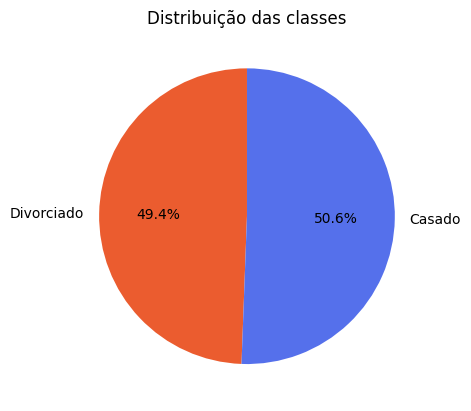

In [12]:
# gráfico de pizza com a distribuição das classes
labels = 'Divorciado', 'Casado'
sizes = [len(divorce_dataset[divorce_dataset['class'] == 1]), len(divorce_dataset[divorce_dataset['class'] == 0])]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#EB5C2F','#5570EB'])
plt.title('Distribuição das classes')
plt.show()

In [13]:
#nome dos atributos
attributes_name_list = divorce_dataset.columns.tolist()[0:-1]

#nome do atributo meta
meta_attribute = divorce_dataset.columns.tolist()[-1]

In [14]:
#entropia total do conjunto de dados
print(calculate_entropy(divorce_dataset, meta_attribute))

0.9999


In [15]:
#calcula o ganho de informação de cada atributo
gain_list = []

for attribute in attributes_name_list:
    gain_list.append(calculate_information_gain(divorce_dataset,meta_attribute,attribute))

gain_df = pd.DataFrame({'attribute': attributes_name_list, 'gain': gain_list})
gain_df.sort_values(by='gain', ascending=False, inplace=True, ignore_index=True)
gain_df['question'] = [question_dict[x]["question"] for x in gain_df['attribute']]

gain_df[['attribute','question', 'gain']].to_csv('gain.csv', index=False, sep=';', decimal=',')

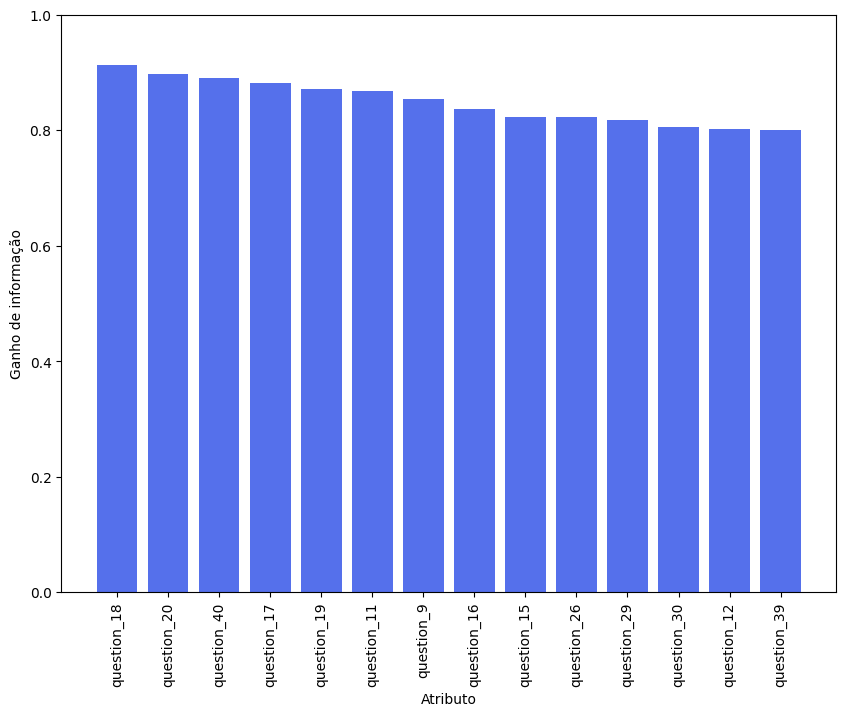

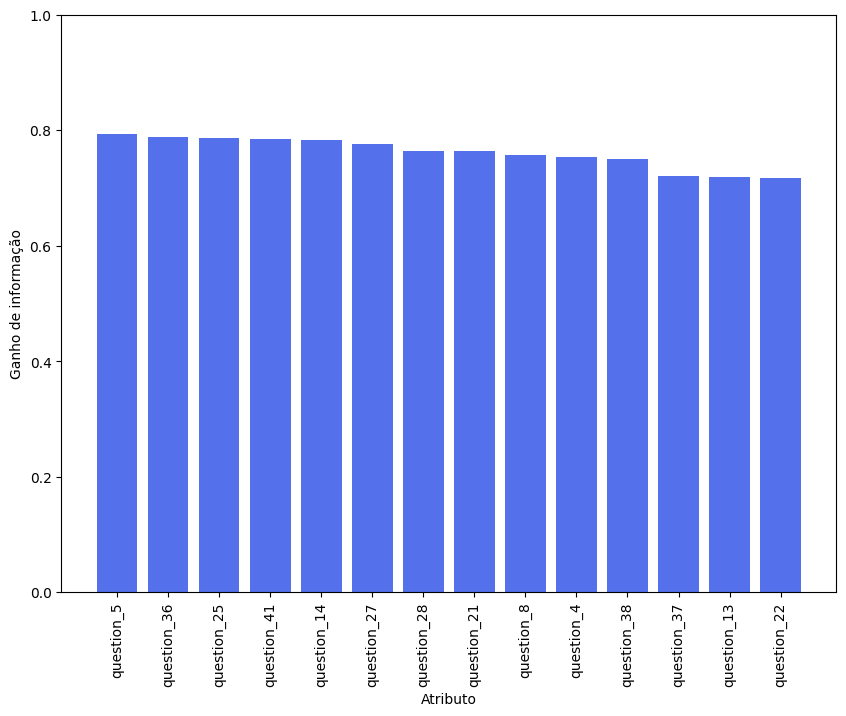

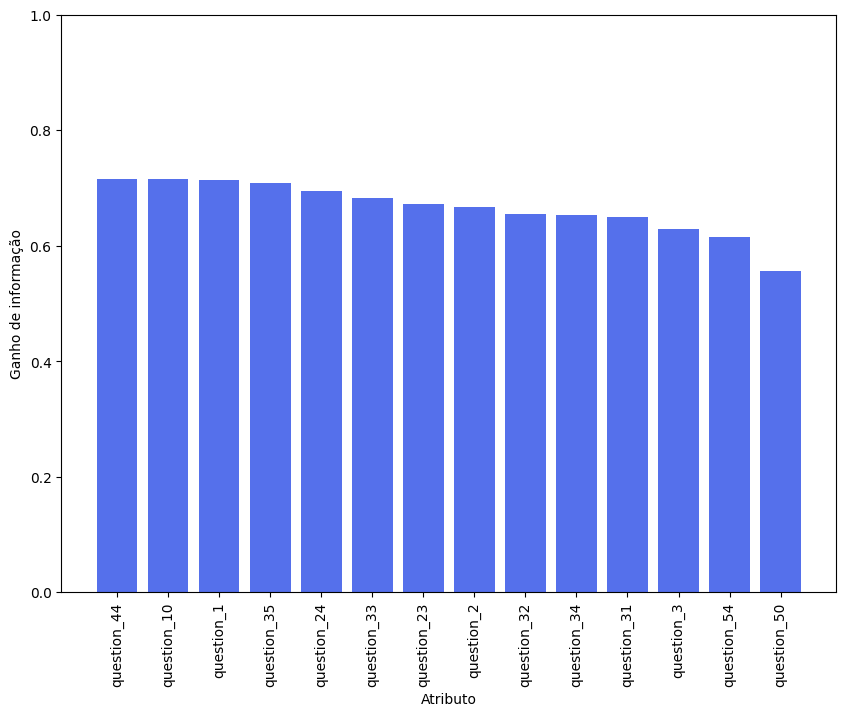

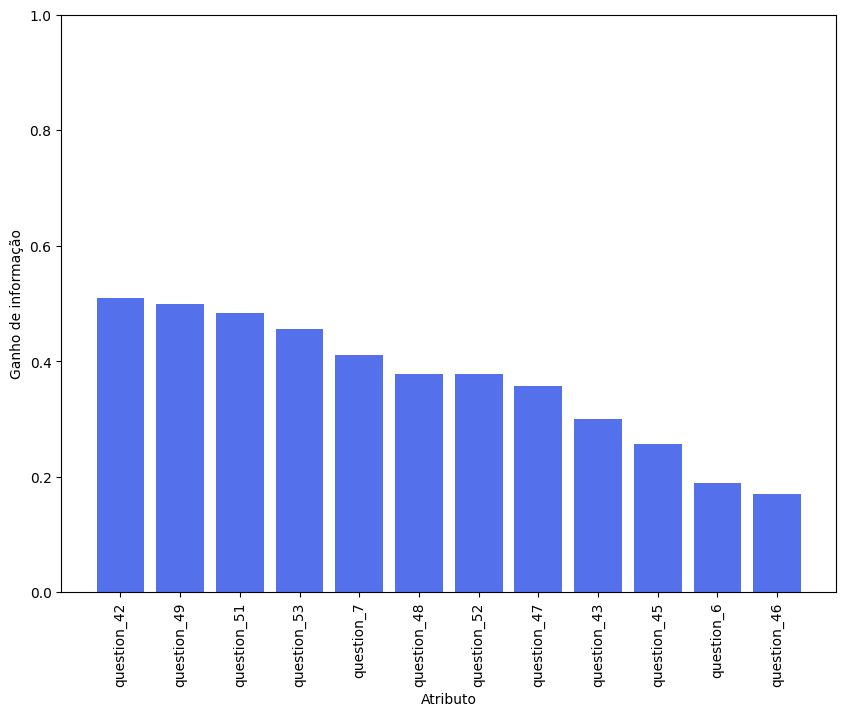

In [16]:
n = 4 #divide o gráfico em n partes

init = 0
step = ceil(len(gain_df) / n)

for i in range(n):
    start = i * step
    end = min(start + step, len(gain_df))
    
    plt.figure(figsize=(10, 7.5))
    plt.bar(gain_df['attribute'][start:end], gain_df['gain'][start:end], color='#5570EB')
    plt.xticks(rotation=90)
    plt.xlabel('Atributo')
    plt.ylabel('Ganho de informação')
    plt.ylim(0, 1)
    plt.show()
